In [2]:
import numpy as np
import matplotlib.pyplot as plt
import filterpy


In [3]:
from osgeo import gdal
import re
import numpy as np
import datetime
import os
import pandas as pd
# import xarray as xr

class PixelTS(object):
    '''
    pixel wise time series data producer

    Methods:
    ------------------
    :generator() - generator; return pixel time series data
    :singlePixel - return pixel time series data

    Attributes:
    ------------------
    :self.pixelts - pandas.DataFrame; pixel time series
    '''
    def __init__(self):
        self.products= ['radar', 'satellite', 'gauge']
        _data= self.getProductData(self.products[0])
        self.size= list(_data.values())[0].shape
        self._df= pd.DataFrame(index=_data.keys(), columns=['radar', 'satellite', 'gauge'])
        # self._df.index= pd.to_datetime(self._df.index, format='%Y%m%d%H')

    def generator(self):

        for ii in self.size[0]:
            for jj in self.size[1]:
                yield singlePixel(ii,jj)

    def singlePixel(self, i, j):
        for product in self.products:
            _data= self.getProductData(product)
            for it, arr in _data.items():
                self._df.loc[it,product]= arr[i,j]

        return self._df

    def getProductData(self, product):
        return ProductData(product).ts

    @property
    def pixelts(self):
        return self._df


class ProductData(object):
    '''
    Load product data into time series dictionary

    Arguments:
    ------------------
    :product - str; one of [radar, satellite, gauge]
    :folder - list; ordered list [radar, satellite, gauge]

    Attributes:
    ------------------
    :self.ts - dict; {datetime: array}; return time series data
    '''

    def __init__(self, product, folder=None):

        self.product= product
        self.folder= folder
        if self.folder is None:
            if self.product== 'radar':
                # folder= '../cleaned/radars'
                folder= '../../cleaned/Harvey_mrms'
            elif self.product== 'satellite':
                # folder= '../cleaned/satellites'
                folder= '../../cleaned/Harvey_GPM'
            elif self.product== 'gauge':
                # folder= '../cleaned/gauges'
                folder= '../../cleaned/Harvey_gauge'
        else:
            radar= self.folder[0]
            satellite= self.folder[1]
            gauge= self.floder[2]
        # load time series
        self._ts_data= self.loadTS(folder, product)

    def loadTS(self, folder, product):
        files= sorted(os.listdir(folder))
        # print(files)
        duration= len(files)
        ts_dict= {}
        for i, file in enumerate(files):
            if file.endswith('.tif'):
                obj= GeoData(file, folder, product)
                timestamp= obj.getDateTime().strftime('%Y%m%d%H')
                data= obj.data
                ts_dict[timestamp]= data

        return ts_dict

    #TODO read as xarray
    def loadxr(self):
        pass

    @property
    def ts(self):
        return self._ts_data


class GeoData(object):
    '''
    This creates data object to facilitate geo-referenced data process
    The framework used to process .tif file is GDAL

    Methods:
    --------------------
    .getDateTime - return date time with sigle file's name
    .getGeoProjection - return projection
    .getGeoTransform - necessary if do affine transform
    .getDict - paired {date: data} per time stamp
    .visualize - plot time series along assigned pixel
    '''

    def __init__(self, src, folder, dType= 'satellite'):
        self.file_name= src
        self.type= dType
        self.obj= gdal.Open(os.path.join(folder,src))

    def getDateTime(self):
        if self.type== 'satellite':
            timestamp= self._satName()
        elif self.type== 'radar':
            timestamp= self._radName()
        elif self.type== 'gauge':
            timestamp= self._gauName()
        else:
            raise ValueError('expected type to be one of satellite, radar and gauge')

        return timestamp

    def getDict(self, key):
        timestamp= self.getDateTime()
        data= self.obj.ReadAsArray().astype(np.float32)
        paired= {'data': data,
                'datetime': self.getDateTime()}

        return paired

    @property
    def data(self):
        return self.obj.ReadAsArray()


    def _satName(self):
        # this function returns date and time from satellite file name
        date_parttern= r'(201[5-9][0-1][0-9][0-3][0-9])'
        time_parttern= r'(S[0-2][0-9]0000)'
        date= re.search(date_parttern, self.file_name).group()
        time= re.search(time_parttern, self.file_name).group()[1:]

        return datetime.datetime.strptime(date+time, '%Y%m%d%H%M%S')

    def _radName(self):
        # this function returns date and time from satellite file name
        date_parttern= r'(201[5-9][0-1][0-9][0-3][0-9])'
        time_parttern= r'(-[0-2][0-9]0000)'
        date= re.search(date_parttern, self.file_name).group()
        time= re.search(time_parttern, self.file_name).group()[1:]

        return datetime.datetime.strptime(date+time, '%Y%m%d%H%M%S')

    def _gauName(self):
        # this function returns date and time from satellite file name
        date_parttern= r'(201[5-9][0-1][0-9][0-3][0-9][0-2][0-9])'
        date= re.search(date_parttern, self.file_name).group()[:8]
        time= re.search(date_parttern, self.file_name).group()[8:]
        # print(date, time)

        return datetime.datetime.strptime(date+time, '%Y%m%d%H')

In [4]:
'''
Triple Collocation Method
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from osgeo import gdal
import multiprocessing
from functools import partial

class TripleCollocation(object):
    '''
    About Triple Collocation, see provided .pdf file
    Main Program

    Methods:
    -----------------

    '''

    def __init__(self):
        pass

    def ts_tc(self,cores=4):
        i=208; j=293
        RMSE= np.zeros((7, 208,293,3), dtype=np.float16)
        CC= np.zeros((7, 208, 293,3), dtype=np.float16)
        inputs= [(i,j) for i in range(10) for j in range(10)]
        pool= multiprocessing.Pool(cores)
        results= pool.map(self._ts_tc_single, inputs)
        for result in results:
            i,j,r,c= result
            RMSE[:,i,j,:]= r
            CC[:,i,j,:]= c
        RMSE_radar= RMSE[:, :,:,0]
        RMSE_sat= RMSE[:,:,:,1]
        RMSE_gauge= RMSE[:,:,:,2]

        CC_radar= CC[:,:,:,0]
        CC_sat= CC[:,:,:,1]
        CC_gauge= CC[:,:,:,2]

        for day in range(7):
            self.write_geotif('TCresults/rmse_radar_mtc_day_%d.tif'%day, RMSE_radar[day,:,:])
            self.write_geotif('TCresults/rmse_sat_mtc_day_%d.tif'%day,  RMSE_sat[day,:,:])
            self.write_geotif('TCresults/rmse_gauge_mtc_day_%d.tif'%day, RMSE_gauge[day,:,:])

            self.write_geotif('TCresults/cc_radar_mtc_day_%d.tif'%day, CC_radar[day,:,:])
            self.write_geotif('TCresults/cc_sat_mtc_day_%d.tif'%day,  CC_sat[day,:,:])
            self.write_geotif('TCresults/cc_gauge_mtc_day_%d.tif'%day, CC_gauge[day,:,:])


    def main(self):
        i= 208; j= 293
        RMSE= np.zeros((i*j,3), dtype=np.float16)
        CC= np.zeros((i*j,3), dtype=np.float16)
        ind=0
        for ii in range(i):
            for jj in range(j):
                print('processing (%d,%d)'%(ii,jj))
                ts= self.preprocess(ts)
                ts[ts<0]= 0
                if len(ts)==0 or len(ts)<3:
                    RMSE[ind,:]= -9999
                    CC[ind,:]= -9999
                else:
                    _sig, _r= self.mtc(ts)
                    RMSE[ind,:]= _sig
                    CC[ind,:]= _r
        RMSE_radar= RMSE[:,0].reshape(i,j)
        RMSE_sat= RMSE[:,1].reshape(i,j)
        RMSE_gauge= RMSE[:,2].reshape(i,j)

        CC_radar= CC[:,0].reshape(i,j)
        CC_sat= CC[:,1].reshape(i,j)
        CC_gauge= CC[:,2].reshape(i,j)

        return (RMSE_radar, RMSE_sat, RMSE_gauge), (CC_radar, CC_sat, CC_gauge)

    def parallel(self, cores=6, write=False):
        RMSE= np.zeros((208,293,3), dtype=np.float16)
        CC= np.zeros((208, 293,3), dtype=np.float16)
        # inputs= [(i,j) for i in range(100,130) for j in range(100,140)]
        inputs= [(i,j) for i in range(208) for j in range(293)]
        pool= multiprocessing.Pool(cores)
        results= pool.map(self.single, inputs)
        for r,c,i,j in results:
            RMSE[i,j,:]= r
            CC[i,j,:]= c
        RMSE_radar= RMSE[:,:,0]
        RMSE_sat= RMSE[:,:,1]
        RMSE_gauge= RMSE[:,:,2]

        CC_radar= CC[:,:,0]
        CC_sat= CC[:,:,1]
        CC_gauge= CC[:,:,2]

        if write:
            self.write_geotif('TCresults/rmse_radar.tif',RMSE_radar)
            self.write_geotif('TCresults/rmse_sat.tif',  RMSE_sat)
            self.write_geotif('TCresults/rmse_gauge.tif',RMSE_gauge)

            self.write_geotif('TCresults/cc_radar.tif',CC_radar)
            self.write_geotif('TCresults/cc_sat.tif',  CC_sat)
            self.write_geotif('TCresults/cc_gauge.tif',CC_gauge)

            # self.write_geotif('test.tif', np.zeros((208,293)))

        return RMSE, CC

    def single(self, args):
        i,j = args
        print('processing (%d,%d)'%(i,j))
        RMSE= np.zeros(3, dtype=np.float16)
        CC= np.zeros(3, dtype=np.float16)
        ts= PixelTS().singlePixel(i,j)
        ts.radar= ts.radar.shift()
        ts.satellite= ts.satellite.shift()
        ts= self.preprocess(ts)
        # print('length of ts: ', len(ts))
        if len(ts)==0 or len(ts)<3:
            RMSE[:]= np.array([-9999]*3)
            CC[:]= np.array([-9999]*3)
        else:
            # print(ts.columns)
            _sig, _r= self.mtc(ts)
            RMSE[:]= _sig
            CC[:]= _r

        return RMSE, CC, i,j

    def _ts_tc_single(self, args):
        i,j= args
        print('processing (%d-%d)'%(i,j))
        RMSE= np.zeros((7, 3), dtype=np.float16)
        CC=np.zeros((7, 3), dtype=np.float16)
        ts= PixelTS().singlePixel(i,j)
        # print(ts.radar)
        ts.index= pd.to_datetime(ts.index, format='%Y%m%d%H')
        # print(type(ts.index))
        days= set(ts.index.day.values)
        for i, day in enumerate(days):
            partial_ts= ts[ts.index.day==day]
            partial_ts= self.preprocess(partial_ts)
            if len(partial_ts)==0 or len(partial_ts)<3:
                RMSE[i,:]= np.array([-9999]*3)
                CC[i, :]= np.array([-9999]*3)
            else:
                _sig, _r= self.mtc(partial_ts)
                RMSE[i,:]= _sig
                CC[i, :]= _r

        return i,j, RMSE, CC


    def preprocess(self, data, threshold1=0, threshold2=0.01):
        # this function drops nan and values between thresholds
        data= data.astype('float32')
        cols= data.columns
        for col in cols:
            # data= data.apply(np.log)
            data=data[data[col]>=threshold2]
            data.clip(lower=threshold2, inplace=True)
            # data.dropna(inplace=True)
        # print(data)
        data= data.apply(np.log)
        return data


    def mtc(self, X):
        #check X has shape (time sequence, 3)
        N_boot= 500
        rmse= np.zeros((N_boot,3))
        cc= np.zeros((N_boot, 3))
        for i in range(N_boot):
            sigma= np.zeros(3)
            r= np.zeros(3)
            sample= self.bootstrap_resample(X, n=N_boot)
            # print(X.columns)

            cov= sample.cov().to_numpy()
            # print(cov)
            # compute RMSE
            if (cov==0).any().any():
                rmse[i,:]=np.nan
                cc[i,:]= np.nan
            else:
                sigma[0]= cov[0,0] - (cov[0,1]*cov[0,2])/(cov[1,2])
                sigma[1]= cov[1,1] - (cov[0,1]*cov[1,2])/(cov[0,2])
                sigma[2]= cov[2,2] - (cov[0,2]*cov[1,2])/(cov[0,1])
                # print(cov[0,0], cov[1,1], cov[2,2])

                sigma[sigma<0]= np.nan
                sigma= sigma**.5

                #compute correlation coefficient
                r[0] = (cov[0,1]*cov[0,2])/(cov[0,0]*cov[1,2])
                r[1] = (cov[0,1]*cov[1,2])/(cov[1,1]*cov[0,2]);
                r[2] = (cov[0,2]*cov[1,2])/(cov[2,2]*cov[0,1]);

                #sign function here?
                r[r<0] = 0.0001
                r[r>1] = 1
                r= r**.5
                r[r<1e-3] = 0

                rmse[i,:]= sigma
                cc[i, :]= r

        return np.nanmean(rmse, axis=0), np.nanmean(cc,axis=0)




    def bootstrap_resample(self, X, n=None):
        """ Bootstrap resample an array_like
        Parameters
        ----------
        X : pandas data frame
          data to resample
        n : int, optional
          length of resampled array, equal to len(X) if n==None
        Results
        -------
        returns X_resamples
        """
        if n == None:
            n = len(X)

        resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
        X_resample = X.iloc[resample_i, :]
        return X_resample

    def write_geotif(self, dst, new_array):
        #read sample
        pth= '../cleaned/gauge4km/ST2gg2017082500.Grb.tif'
        sample= gdal.Open(pth)
        projection= sample.GetProjection()
        trans= sample.GetGeoTransform()
        bands= 1
        driver= gdal.GetDriverByName("GTiff")
        rows, cols= new_array.shape

        outdata = driver.Create(dst, cols, rows, bands, gdal.GDT_Float32)

        outdata.SetGeoTransform(trans)
        outdata.SetProjection(projection)
        outdata.GetRasterBand(bands).WriteArray(new_array)
        outdata.FlushCache()
        outdata = None


In [26]:
pixel= PixelTS()
ts= pixel.singlePixel(126,150)
tc= TripleCollocation()
RMSE, CC, _, _= tc.single((126,150))

processing (126,150)


In [27]:
RMSE

array([2.889, 3.465, 2.957], dtype=float16)

In [6]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

In [28]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_discrete_white_noise(dim=3, dt=1, var= 1)

In [29]:
ts[ts<0]= np.nan

In [30]:
from pandas.plotting import autocorrelation_plot

In [31]:
ts= ts.astype(float)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

In [33]:
radar_std= scaler.fit_transform(ts.radar.values.reshape(-1,1))
satellite_std= scaler.fit_transform(ts.satellite.values.reshape(-1,1))
gauge_std= scaler.fit_transform(ts.gauge.values.reshape(-1,1))

In [34]:
a_radar= np.nanmean(radar_std[1:]*radar_std[:-1])
a_satellite= np.nanmean(satellite_std[1:]*satellite_std[:-1])
a_gauge= np.nanmean(gauge_std[1:]*gauge_std[:-1])
b_radar= np.sqrt(1-a_radar**2)
b_satllite= np.sqrt(1-a_satellite**2)
b_gauge= np.sqrt(1-a_gauge**2)

In [43]:
P= np.diag(RMSE)
F= np.array([[a_radar,0,0],
             [0,a_satellite,0],
             [0,0,a_gauge]])
B= np.array([b_radar, b_satllite, b_gauge])

def hx(x):
    return (np.array([CC[0], CC[1], CC[2]])*x).sum()

def fx(x, dt):
    return np.dot(F, x)

x= ts.mean(axis=0).values
dt= 1
f= EnKF(x=x, P=P, dim_z=3, dt=dt, N=5000, hx= hx, fx=fx)

f.R =2
f.Q= Q

results= []
i=0
while True:
    z = ts.iloc[i,:].values.T
    f.predict()
    f.update(np.asarray(z))
    results.append(f.x.mean())
    i+=1
    if i>=len(ts): break

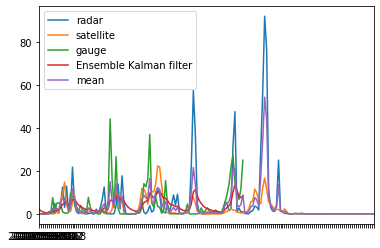

In [45]:
ts.plot()
plt.plot(ts.index, results, label='Ensemble Kalman filter')
plt.plot(ts.index, [np.nanmean(ts.iloc[i,:]) for i in range(len(ts))], label='mean')
plt.legend()
plt.show()
# results

In [136]:
# -*- coding: utf-8 -*-
# pylint: disable=invalid-name, too-many-arguments, too-many-instance-attributes
# pylint: disable=attribute-defined-outside-init

"""Copyright 2015 Roger R Labbe Jr.

FilterPy library.
http://github.com/rlabbe/filterpy

Documentation at:
https://filterpy.readthedocs.org

Supporting book at:
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

This is licensed under an MIT license. See the readme.MD file
for more information.
"""


from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from copy import deepcopy
import numpy as np
from numpy import dot, zeros, eye, outer
from numpy.random import multivariate_normal
from filterpy.common import pretty_str


class EnsembleKalmanFilter(object):
    """
    This implements the ensemble Kalman filter (EnKF). The EnKF uses
    an ensemble of hundreds to thousands of state vectors that are randomly
    sampled around the estimate, and adds perturbations at each update and
    predict step. It is useful for extremely large systems such as found
    in hydrophysics. As such, this class is admittedly a toy as it is far
    too slow with large N.

    There are many versions of this sort of this filter. This formulation is
    due to Crassidis and Junkins [1]. It works with both linear and nonlinear
    systems.

    Parameters
    ----------

    x : np.array(dim_x)
        state mean

    P : np.array((dim_x, dim_x))
        covariance of the state

    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.

    dt : float
        time step in seconds

    N : int
        number of sigma points (ensembles). Must be greater than 1.

    K : np.array
        Kalman gain

    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.

    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x.


    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate

    P : numpy.array(dim_x, dim_x)
        State covariance matrix

    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.

    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.

    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.

    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.

    z : numpy.array
        Last measurement used in update(). Read only.

    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix

    Q : numpy.array(dim_x, dim_x)
        Process noise matrix

    fx : callable (x, dt)
        State transition function

    hx : callable (x)
        Measurement function. Convert state `x` into a measurement

    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.

    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv

    Examples
    --------

    .. code-block:: Python

        def hx(x):
           return np.array([x[0]])

        F = np.array([[1., 1.],
                      [0., 1.]])
        def fx(x, dt):
            return np.dot(F, x)

        x = np.array([0., 1.])
        P = np.eye(2) * 100.
        dt = 0.1
        f = EnKF(x=x, P=P, dim_z=1, dt=dt, N=8,
                 hx=hx, fx=fx)

        std_noise = 3.
        f.R *= std_noise**2
        f.Q = Q_discrete_white_noise(2, dt, .01)

        while True:
            z = read_sensor()
            f.predict()
            f.update(np.asarray([z]))

    See my book Kalman and Bayesian Filters in Python
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

    References
    ----------

    - [1] John L Crassidis and John L. Junkins. "Optimal Estimation of
      Dynamic Systems. CRC Press, second edition. 2012. pp, 257-9.
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)


    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.

        Parameters
        ----------

        z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z) #3
        sigmas_h = zeros((N, dim_z)) #(1000,3)

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i]) #(1000,3)

        z_mean = np.mean(sigmas_h, axis=0) #(1,3)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean  #(1,3)
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R #(3,3)
        self.S = P_zz
        self.SI = self.inv(self.S)

#         print('z_mean:', z_mean.shape, 'sigmas_h:',sigmas_h.shape)
        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean) #(3,3)
#             print((self.sigmas[i] - self.x).shape, (sigmas_h[i] - z_mean).shape)
        P_xz /= N-1

        self.K = dot(P_xz, self.inv(P_zz)) #(3,3)

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)


    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx)
            ])

In [20]:
ts.max()

radar        30.215445
satellite    32.188038
gauge        28.799999
dtype: float64

In [36]:
RMSE

array([2.096, 5.18 , 2.955], dtype=float16)